# Voice Identification

### n-shot learning

The idea of one shot learning is to train an algorithm so that after only `n` examples, an algorithm can identify a example again. 

Siamese networks attempt to do this by training a model to learn how to take a high dimensional input an generate a feature vector. The network is trained by taking two examples either similar or different and training them to reduce/increase the distance of the feature vector generated by the output.

### Applying to Voice Identification

The end goal of this model is to take a audio sample that has undergone speech diarihsation and identify each speaker in the set.

### Datasets

| Name | Speakers           | Min  | Max
| ------------- |-------------|-----|-----|
[VoxCeleb](http://www.robots.ox.ac.uk/~vgg/data/voxceleb/)| 7000+| 3s | 3s
[10 English Speakers](http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS) | 10 | ? | ? 

### Articles

- https://github.com/zdmc23/oneshot-audio/blob/master/OneShot.ipynb

In [50]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [51]:
import sys
sys.path.append("../audio")
from audio import *
from siamese import *
np.random.seed(2)

In [52]:
path = Config.data_path() / 'voxceleb-small'

In [71]:
config = AudioTransformConfig()
config.segment_size = 1000
config.f_max = 8000
config.to_db_scale = True
config.top_db = 80
config.max_to_pad = 1000
label_pattern = r'/(id(\d+))/'
audios = AudioList.from_folder(path, recurse=True, config=config).split_none().label_from_re(label_pattern)
print("Number of speakers: ", audios.c)

Number of speakers:  66


In [72]:
sds = SiameseDataset.create_from_ll(audios, split_c=.2, pct_same=1, tar_num=10000)

In [78]:
sds.train

SiameseDataset (86939 items)
x: AudioList
ItemTuple<AudioItem>[2],ItemTuple<AudioItem>[2],ItemTuple<AudioItem>[2],ItemTuple<AudioItem>[2],ItemTuple<AudioItem>[2]
y: CategoryList
0,0,0,0,0
Path: /home/h/.fastai/data/voxceleb-small

In [87]:
db = sds.databunch(bs=32)

In [88]:
db.one_batch()

(tensor([[[[[-33.0458, -33.7831, -35.1210,  ..., -31.8545, -30.3158,
             -29.8050],
            [-17.8112, -18.5485, -19.8865,  ..., -16.6200, -15.0813,
             -14.5705],
            [-25.3303, -25.4958, -26.6224,  ..., -24.9902, -23.1807,
             -22.3992],
            ...,
            [-27.6648, -27.9434, -28.7481,  ..., -31.4302, -30.9948,
             -30.7336],
            [-30.2745, -30.3563, -30.5920,  ..., -32.7236, -32.6423,
             -32.5200],
            [-31.5493, -31.6054, -31.7989,  ..., -34.2351, -34.9366,
             -35.1876]]],
 
 
          [[[ -4.8022,  -5.2952,  -6.7179,  ...,  -0.6991,  -0.3523,
              -0.3050],
            [ 10.4323,   9.9393,   8.5166,  ...,  14.5354,  14.8822,
              14.9296],
            [ -7.1710,  -4.3471,  -1.0623,  ...,   2.5170,  -1.3814,
              -7.2948],
            ...,
            [-23.5258, -23.9313, -25.1761,  ...,  -9.0572,  -9.1051,
              -9.1339],
            [-21.8510, -22.269

In [75]:
learn = siamese_learner(db)
newlayer = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
newlayer = newlayer.cuda() # Our layer should use cuda, since the rest of the model will.
learn.model.body[0] = newlayer

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


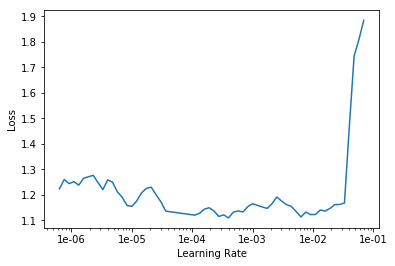

In [76]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, 1e-4)